<a href="https://colab.research.google.com/github/Rnajnar/Intensity_Analysis-/blob/main/Intensity_Analysis_RashmiRanjan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:40px; font-weight:700">Intensity Analysis(Emotion Classification)</h1>

In [338]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [339]:
import re
import string
import unicodedata
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split, ParameterGrid

# Bag-of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# BOW
from sklearn.feature_extraction.text import CountVectorizer

# Classifiers
!pip install scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# word2Vec
import gensim.downloader as api
import matplotlib.patches as mpatches
import matplotlib
from sklearn.decomposition import TruncatedSVD
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix


In [340]:
# Load each CSV file into a DataFrame
happy_df = pd.read_csv("/content/drive/MyDrive/Capstone Project/Intensity_data/happiness.csv")
angry_df = pd.read_csv("/content/drive/MyDrive/Capstone Project/Intensity_data/angriness.csv")
sad_df = pd.read_csv("/content/drive/MyDrive/Capstone Project/Intensity_data/sadness.csv")

In [341]:
# Concatenate the three DataFrames into one
emotion_df = pd.concat([happy_df, angry_df, sad_df], ignore_index=True)

In [342]:
# Shuffle the combined DataFrame to randomize the order
emotion_df = emotion_df.sample(frac=1).reset_index(drop=True)

In [343]:
emotion_df.head()

,content,intensity
0,Love is in your heart.. Peace is in you nerves...,happiness
1,"""PERFECT MATURITY"" is when a person hurts you,...",sadness
2,Love me for a second and I'll love you forever.,happiness
3,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness
4,Sometimes you just need to maintain a distance...,happiness


In [344]:
emotion_df['content'].iloc[0]

'Love is in your heart.. Peace is in you nerves.. Truth is in your mind.'

In [345]:
emotion_df.isnull().sum()

,0
content,0
intensity,0


In [346]:
emotion_df.duplicated().sum()

447

In [347]:
emotion_df[emotion_df.duplicated()]

,content,intensity
7,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness
13,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness
52,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness
53,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness
57,"['You Hurt Me But I Still Love You.', 'True Lo...",sadness
...,...,...
2029,"Dear Feelings, i need you to move on.",sadness
2032,Don't ask why someone keep hurting you. ASk yo...,sadness
2035,"Beware, I’m not in my greatest mood today.",angriness
2036,Loneliness is better than a bad company.,sadness


In [348]:
emotion_df[emotion_df.duplicated()]['content'].iloc[0]

"['Hating Me Won’T Make You Pretty.', 'Anger Is One Letter Short Of Danger.', 'I Am If I Changed, But You Changed Too.', 'Anger Is My Power So Don’t Make Me Angry.', 'Even The Nicest People Have Their Limits.', 'Whatever Is Begun In Anger Ends In Shame.', 'Don’T Make Me Angry And Change Your Status.', 'Silence Is The Best Way To React While Angry. ( Angry Whatsapp Status\\xa0', 'I Hope Karma Slaps You In The Face Before I Do.', 'An Angry Man Opens His Mouth And Shuts His Eyes.', 'I Am Not In A Bad Mood, Everyone Is Just Annoying.', 'A Quick Temper Will Make A Fool Of You Soon Enough.', 'Yes I Am Smiling But You Are Not The Reason Anymore.', 'My Attitude Will Always Be Based On How You Treat Me.', 'You Blocked Me On Facebook & Noe You’Re Going To Die.', 'Anger Tears Me Up Inside…My Own…Or Anyone Else’S. (\\xa0Angry\\xa0Quotes\\xa0', 'You Should Make A Woman Angry If You Wish Her To Love.', 'Sometimes I’M Not Angry. I’M Hurt And There’S A Big Diff.', 'Never Go To Bed Angry, Stay Awake An

In [349]:
# Dropping observations with missing values
emotion_df.dropna(inplace = True)
# Dropping duplicate observations
emotion_df.drop_duplicates(inplace = True)
 # Resetting index
emotion_df.reset_index(drop = True, inplace = True)

In [350]:
emotion_df.shape

(1592, 2)

<div style="background-color:#f5deb3; padding:12px;border-radius:12px">
    <h2>Distribution of Intensity:</h2>
    <ul>
    <li>The 'intensity' column indicates the emotional intensity associated with each text entry, with three categories: 'happiness', 'angriness', and 'sadness'.</li>
    </ul>
 </div>

In [351]:
emotion_df['intensity'].value_counts()

,count
intensity,
happiness,704
angriness,498
sadness,390


In [352]:
intensity_mapping = {
    'happiness': 0,
    'angriness':1,
    "sadness":2
}

emotion_df['intensity_enc'] = emotion_df['intensity'].map(intensity_mapping)

In [353]:
emotion_df.head()

,content,intensity,intensity_enc
0,Love is in your heart.. Peace is in you nerves...,happiness,0
1,"""PERFECT MATURITY"" is when a person hurts you,...",sadness,2
2,Love me for a second and I'll love you forever.,happiness,0
3,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness,1
4,Sometimes you just need to maintain a distance...,happiness,0


**EDA - Content length across intensities**

In [354]:
emotion_df['content_len'] = emotion_df['content'].apply(lambda x: len(x.split(' ')))
emotion_df.head()

,content,intensity,intensity_enc,content_len
0,Love is in your heart.. Peace is in you nerves...,happiness,0,15
1,"""PERFECT MATURITY"" is when a person hurts you,...",sadness,2,20
2,Love me for a second and I'll love you forever.,happiness,0,10
3,"['Hating Me Won’T Make You Pretty.', 'Anger Is...",angriness,1,1500
4,Sometimes you just need to maintain a distance...,happiness,0,14


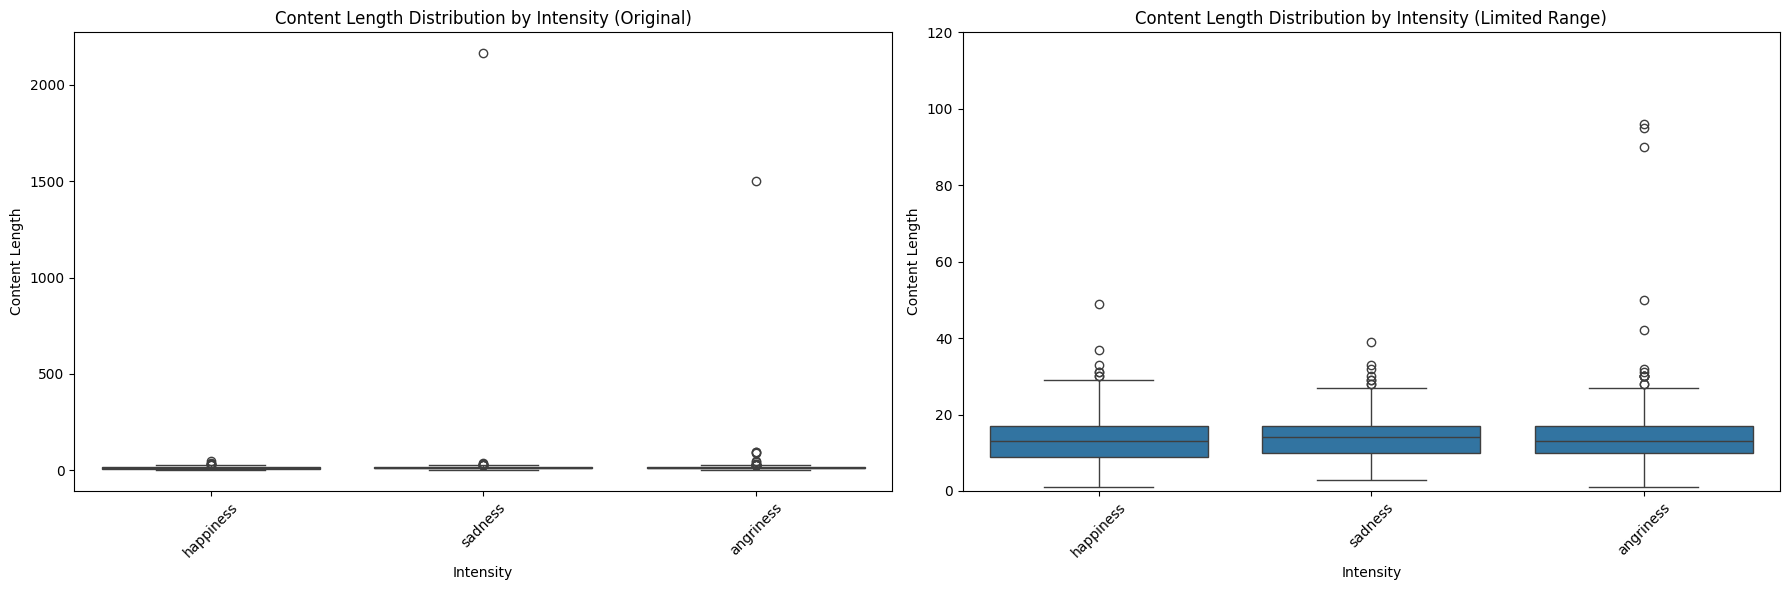

In [355]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the original boxplot without setting y-axis limits
sns.boxplot(ax=axes[0], x='intensity', y='content_len', data=emotion_df)
axes[0].set_title('Content Length Distribution by Intensity (Original)')
axes[0].set_xlabel('Intensity')
axes[0].set_ylabel('Content Length')
axes[0].tick_params(axis='x', rotation=45)

# Plot the boxplot with y-axis limits
sns.boxplot(ax=axes[1], x='intensity', y='content_len', data=emotion_df)
axes[1].set_title('Content Length Distribution by Intensity (Limited Range)')
axes[1].set_xlabel('Intensity')
axes[1].set_ylabel('Content Length')
axes[1].set_ylim(0, 120)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()

**Inference:The box-plot of sadness compared to other two, shows that, Sadness may be expressed concisely in some cases.**

**Intensity Distribution**

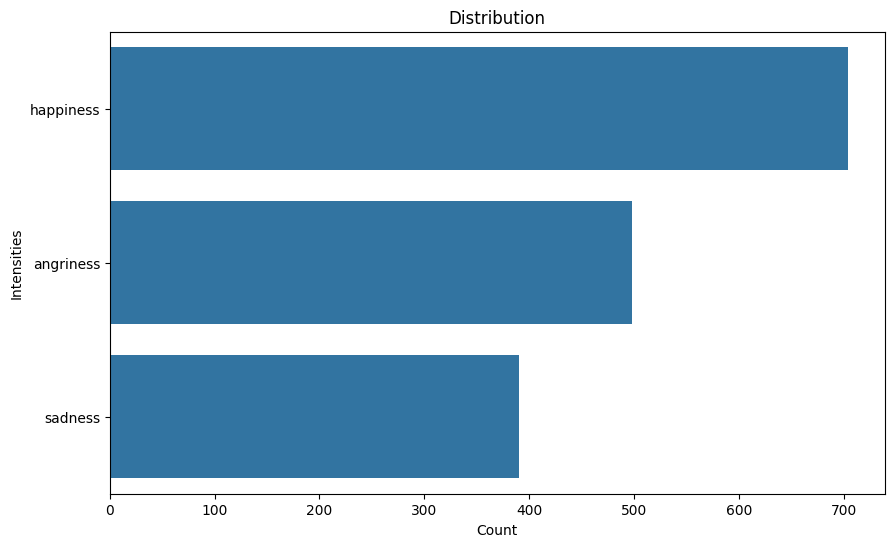

In [356]:
plt.figure(figsize=(10, 6))
sns.countplot(y="intensity", data=emotion_df, order=emotion_df['intensity'].value_counts().index)
plt.title('Distribution')
plt.xlabel('Count')
plt.ylabel('Intensities')
plt.show()

The dataset contains more categories of **Happiness** followed by **Angriness** and **Sadness**. This implies that when humans are happy, they tend to send longer and more messages compared to when they are angry or sad.

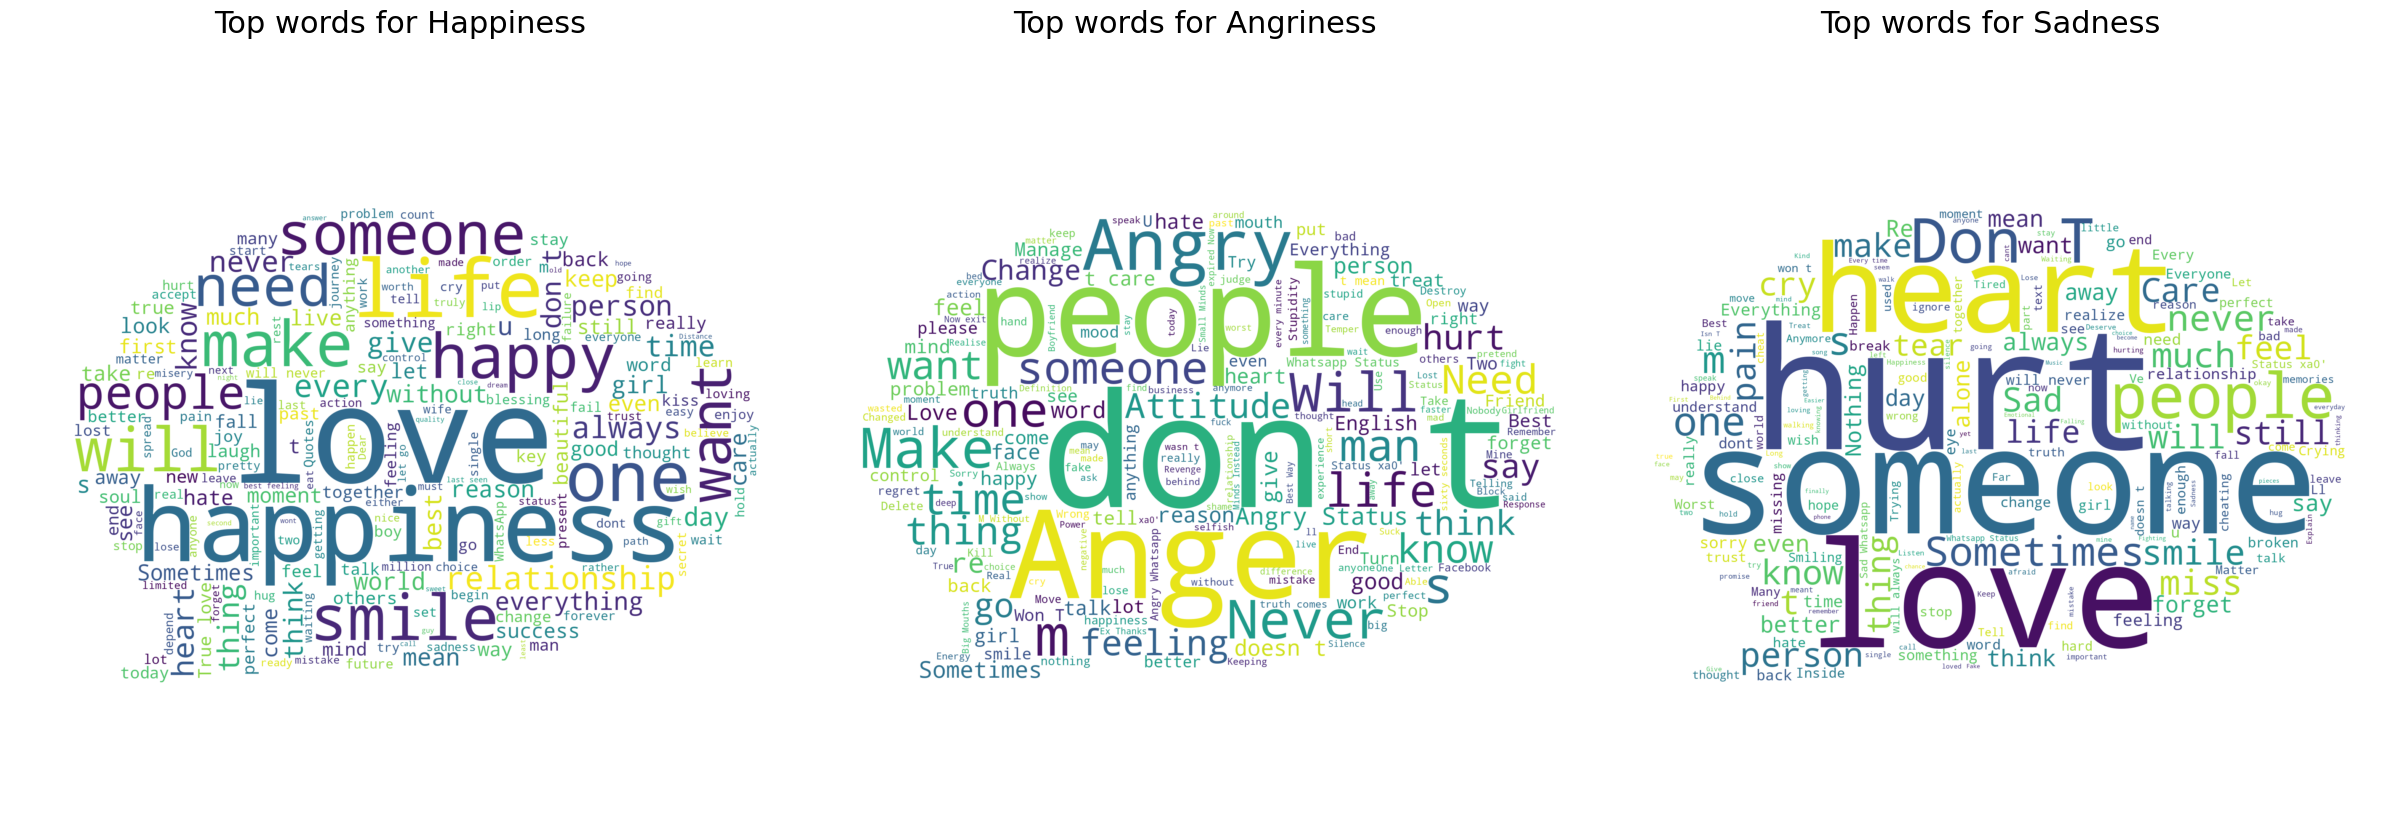

In [357]:
# Load the mask image
comment_mask = np.array(Image.open('/content/drive/MyDrive/Capstone Project/Images/comment.png'))

# Function to generate word cloud
def generate_wordcloud(text, title, ax):
    wc = WordCloud(
        background_color='white',
        max_words=200,
        mask=comment_mask,
    )
    wc.generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontdict={'size': 22, 'verticalalignment': 'bottom'})
    ax.axis('off')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 15))

# Define the categories
categories = ['happiness', 'angriness', 'sadness']

# Generate word clouds for each category and add to subplots
for i, category in enumerate(categories):
    text = ' '.join(emotion_df.loc[emotion_df['intensity'] == category, 'content'])
    generate_wordcloud(text, f'Top words for {category.capitalize()}', axes[i])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Train-Validation-Test Split**

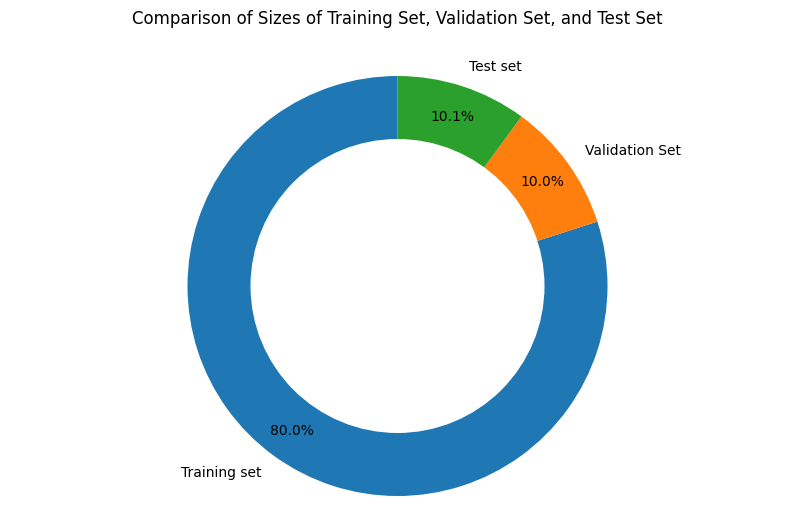

In [358]:
# Feature-target split
X = emotion_df['content']
y = emotion_df['intensity_enc']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 121)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 121)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Add a title
plt.title('Comparison of Sizes of Training Set, Validation Set, and Test Set', y=1.05)

# Show the plot
plt.show()

**Text Normalization**

In [359]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

**Converting to Lowercase**

In [360]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


**Removal of Whitespaces**

In [361]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


**Removal of Punctuations**

In [362]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


**Removal of Unicode Characters**

In [363]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = ' <a href = "https://www.Capstone_Project.com/code/Rashmi_Ranjan/intensity-classification"> Intensity classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input:  <a href = "https://www.Capstone_Project.com/code/Rashmi_Ranjan/intensity-classification"> Intensity classification </a>
Output:   Intensity classification 


**Removing emojis**

In [364]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [365]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


<div style="background-color:#f5deb3; padding:12px; border-radius:12px;">
    By going through the corpus, I came across problematic characters like <b>â€™</b>, <b>â</b>, and <b>ðŸ™</b>. To handle these, we will create a function.
</div>


In [366]:
def remove_problematic(text):
    # Remove non-ASCII characters using regular expression
    text = re.sub(r'[^\x00-\x7F]+', "'", text)

    # Normalize and encode to remove any remaining non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # Remove any double spaces that may have been introduced
    text = re.sub(' +', ' ', text)

    return text.strip()

text = "it's â function thatâ makeâ canât removesâ€™ iâ€™m ðŸ™ "
print("Input: {}".format(text))
print("Output: {}".format(remove_problematic(text)))

Input: it's â function thatâ makeâ canât removesâ€™ iâ€™m ðŸ™ 
Output: it's ' function that' make' can't removes' i'm '


**Substitution of Acronyms**

In [367]:
acronyms_dict = {
    "aka": "also known as",
    "asap": "as soon as possible",
    "brb": "be right back",
    "btw": "by the way",
    "dob": "date of birth",
    "faq": "frequently asked questions",
    "fyi": "for your information",
    "idk": "i don't know",
    "idc": "i don't care",
    "iirc": "if i recall correctly",
    "imo": "in my opinion",
    "irl": "in real life",
    "lmk": "let me know",
    "lol": "laugh out loud",
    "ngl": "not gonna lie",
    "noyb": "none of your business",
    "nvm": "never mind",
    "ofc": "of course",
    "omg": "oh my god",
    "pfa": "please find attached",
    "rofl": "rolling on the floor laughing",
    "stfu": "shut the fuck up",
    "tba": "to be announced",
    "tbc": "to be continued",
    "tbd": "to be determined",
    "tbh": "to be honest",
    "ttyl": "talk to you later",
    "wtf": "what the fuck",
    "wth": "what the heck"
}
print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [368]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


**Substitution of Contractions**

In [369]:
contractions_dict = {
    "'aight": "alright",
    "ain't": "are not",
    "amn't": "am not",
    "arencha": "are not you",
    "aren't": "are not",
    "'bout": "about",
    "can't": "cannot",
    "cap'n": "captain",
    "'cause": "because",
    "'cept": "except",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "dammit": "damn it",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "doesn't": "does not",
    "doin'": "doing",
    "don't": "do not",
    "dunno": "do not know",
    "d'ye": "do you",
    "e'en": "even",
    "e'er": "ever",
    "'em": "them",
    "everybody's": "everybody is",
    "everyone's": "everyone is",
    "fo'c'sle": "forecastle",
    "finna": "fixing to",
    "'gainst": "against",
    "g'day": "good day",
    "gimme": "give me",
    "giv'n": "given",
    "gonna": "going to",
    "gon't": "go not",
    "gotcha": "got you",
    "gotta": "got to",
    "gtg": "got to go",
    "hadn't": "had not",
    "had've": "had have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'll": "he shall",
    "helluva": "hell of a",
    "he's": "he is",
    "here's": "here is",
    "he've": "he have",
    "how'd": "how would",
    "howdy": "how do you do",
    "how'll": "how will",
    "how're": "how are",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i shall",
    "i'm": "i am",
    "imma": "i am about to",
    "i'm'a": "i am about to",
    "i'm'o": "i am going to",
    "innit": "is it not",
    "ion": "i do not",
    "i've": "i have",
    "i'd": "i had",
    "i'd've": "i would have",
    "i'll": "i shall",
    "i'm": "i am",
    "i'm'a": "i am about to",
    "i'm'o": "i am going to",
    "innit": "is it not",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it shall",
    "it's": "it is",
    "iunno": "i do not know",
    "kinda": "kind of",
    "let's": "let us",
    "li'l": "little",
    "ma'am": "madam",
    "mayn't": "may not",
    "may've": "may have",
    "methinks": "me thinks",
    "mightn't": "might not",
    "might've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "must've": "must have",
    "'neath": "beneath",
    "needn't": "need not",
    "nal": "and all",
    "ne'er": "never",
    "o'clock": "of the clock",
    "o'er": "over",
    "ol'": "old",
    "oughtn't": "ought not",
    "'round": "around",
    "'s": "is",
    "shalln't": "shall not",
    "shan't": "shall not",
    "she'd": "she had",
    "she'll": "she shall",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "so're": "so are",
    "so's": "so is",
    "so've": "so have",
    "that'll": "that shall",
    "that're": "that are",
    "that's": "that is",
    "that'd": "that would",
    "there'd": "there had",
    "there'll": "there shall",
    "there're": "there are",
    "there's": "there is",
    "these're": "these are",
    "these've": "these have",
    "they'd": "they had",
    "they'll": "they shall",
    "they're": "they are",
    "they've": "they have",
    "this's": "this is",
    "those're": "those are",
    "those've": "those have",
    "'thout": "without",
    "'til": "until",
    "'tis": "it is",
    "to've": "to have",
    "'twas": "it was",
    "'tween": "between",
    "'twhere": "it were",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we shall",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "whatcha": "what are you",
    "what'd": "what did",
    "what'll": "what shall",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where'll": "where shall",
    "where're": "where are",
    "where's": "where is",
    "where've": "where have",
    "which'd": "which had",
    "which'll": "which shall",
    "which're": "which are",
    "which's": "which is",
    "which've": "which have",
    "who'd": "who would",
    "who'd've": "who would have",
    "who'll": "who shall",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "why'd": "why did",
    "why're": "why are",
    "why's": "why is",
    "willn't": "will not",
    "won't": "will not",
    "wonnot": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd've": "you all would have",
    "y'all'd'n't've": "you all would not have",
    "y'all're": "you all are",
    "y'all'ren't": "you all are not",
    "y'at": "you at",
    "yes'm": "yes madam",
    "yessir": "yes sir",
    "you'd": "you had",
    "you'll": "you shall",
    "you're": "you are",
    "you've": "you have",
    "aight": "alright",
    "aint": "are not",
    "amnt": "am not",
    "arent": "are not",
    "cant": "cannot",
    "cause": "because",
    "couldve": "could have",
    "couldnt": "could not",
    "couldntve": "could not have",
    "darent": "dare not",
    "daresnt": "dare not",
    "dasnt": "dare not",
    "didnt": "did not",
    "doesnt": "does not",
    "doin": "doing",
    "dont": "do not",
    "eer": "ever",
    "everybodys": "everybody is",
    "everyones": "everyone is",
    "finna": "fixing to",
    "gday": "good day",
    "givn": "given",
    "gont": "go not",
    "hadnt": "had not",
    "hadve": "had have",
    "hasnt": "has not",
    "havent": "have not",
    "hed": "he had",
    "hell": "he shall",
    "hes": "he is",
    "heve": "he have",
    "howd": "how did",
    "howdy": "how do you do",
    "howll": "how will",
    "howre": "how are",
    "hows": "how is",
    "idve": "i would have",
    "ill": "i shall",
    "im": "i am",
    "ima": "i am about to",
    "imo": "i am going to",
    "innit": "is it not",
    "ive": "i have",
    "isnt": "is not",
    "itd": "it would",
    "itll": "it shall",
    "its": "it is",
    "lets": "let us",
    "lil": "little",
    "maam": "madam",
    "maynt": "may not",
    "mayve": "may have",
    "methinks": "me thinks",
    "mightnt": "might not",
    "mightve": "might have",
    "mustnt": "must not",
    "mustntve": "must not have",
    "mustve": "must have",
    "neednt": "need not",
    "neer": "never",
    "oclock": "of the clock",
    "oer": "over",
    "ol": "old",
    "oughtnt": "ought not",
    "shallnt": "shall not",
    "shant": "shall not",
    "shed": "she had",
    "shell": "she shall",
    "shes": "she is",
    "shouldve": "should have",
    "shouldnt": "should not",
    "shouldntve": "should not have",
    "somebodys": "somebody is",
    "someones": "someone is",
    "somethings": "something is",
    "thatll": "that shall",
    "thatre": "that are",
    "thatd": "that would",
    "thered": "there had",
    "therell": "there shall",
    "therere": "there are",
    "theres": "there is",
    "thesere": "these are",
    "theseve": "these have",
    "theyd": "they had",
    "theyll": "they shall",
    "theyre": "they are",
    "theyve": "they have",
    "thiss": "this is",
    "thosere": "those are",
    "thoseve": "those have",
    "tis": "it is",
    "tove": "to have",
    "twas": "it was",
    "wanna": "want to",
    "wasnt": "was not",
    "wed": "we had",
    "wedve": "we would have",
    "were": "we are",
    "weve": "we have",
    "werent": "were not",
    "whatd": "what did",
    "whatll": "what shall",
    "whatre": "what are",
    "whats": "what is",
    "whatve": "what have",
    "whens": "when is",
    "whered": "where did",
    "wherell": "where shall",
    "wherere": "where are",
    "wheres": "where is",
    "whereve": "where have",
    "whichd": "which had",
    "whichll": "which shall",
    "whichre": "which are",
    "whichs": "which is",
    "whichve": "which have",
    "whod": "who would",
    "whodve": "who would have",
    "wholl": "who shall",
    "whore": "who are",
    "whos": "who is",
    "whove": "who have",
    "whyd": "why did",
    "whyre": "why are",
    "whys": "why is",
    "wont": "will not",
    "wouldve": "would have",
    "wouldnt": "would not",
    "wouldntve": "would not have",
    "yall": "you all",
    "yalldve": "you all would have",
    "yallre": "you all are",
    "youd": "you had",
    "youll": "you shall",
    "youre": "you are",
    "youve": "you have",
    "'re": "are",
    "that's": "that is",
    "thats": "that is"
}

In [370]:
# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "it's function that make can't removes i'm"

print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: it's function that make can't removes i'm
Output: it is function that make cannot removes i am


**Slangs and Abbreviations Handling**

In [371]:
abbreviations = {
    "$" : "dollar",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
    "lol" : "laugh out loud",
    "lit": "exciting",
    "btw":"by the way",
    # Indian slangs
    "namaste" : "hello",
    "Bakchodi" : "senseless talk",
    "chai-pani" : "bribes",
    "jugaad" : "quick, improvised solution to a problem",
    "chillax" : "calm down",
    "funda" : "basic concept",
    "maggi" : "instant noodles; something quick or easy",
    "firangi" : "foreigner",
    "kya" :  "hey",
    "pinne" : "drink",
    "bhai" : "friend",
    "aaj": "today",
    "jaye": "will go",
    "macha" : "close friend",
    "machi" : "close friend",
    "item" : "attractive person",
    "sutta" : "cigarette",
    "thulla" : "policeman",
    "panga" : "getting into a fight",
    "gedi" : "casual drive",
    "lafda" : "trouble",
    "rs": "rupees",
    "w/o": "without",
    "lol": "laugh out loud",
    "btw": "by the way",
    "bhai": "brother",
    "lit": "exciting",
    "sutta": "cigarette",
    "pinne": "smoke",
    "chalega": "will go"
}



In [372]:
import nltk
nltk.download('punkt_tab')

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in tokens]
    text = ' '.join(tokens)
    return text

text = "w/o lol, that party was so lit last night! BTW, Bhai did you see how many people were taking selfies?"
print("Input 1: {}".format(text))
print("Output 1: {}".format(convert_abbrev_in_text(text)))
print('\n')
text = "Bhai aaj sutta pinne jaye?"
print("Input 2: {}".format(text))
print("Output 2: {}".format(convert_abbrev_in_text(text)))

Input 1: w/o lol, that party was so lit last night! BTW, Bhai did you see how many people were taking selfies?
Output 1: without laugh out loud , that party was so exciting last night ! by the way , brother did you see how many people were taking selfies ?


Input 2: Bhai aaj sutta pinne jaye?
Output 2: brother today cigarette smoke will go ?


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Spelling Correction**

In [373]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


**Stemming and Lemmatization**

In [374]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


In [375]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


**Discardment of Non-alphabetic Words**

In [376]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


**Retainment of Relevant Parts of Speech**

In [377]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRPS','JJ',
                 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP','WP$',
                 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']

    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "I’M sorry If I Change But You Changed Too"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: I’M sorry If I Change But You Changed Too
Tokens: ['I', 'M', 'sorry', 'If', 'I', 'Change', 'But', 'You', 'Changed', 'Too']
Tagged Tokens: [('I', 'PRP'), ('M', 'VBP'), ('sorry', 'JJ'), ('If', 'IN'), ('I', 'PRP'), ('Change', 'VBP'), ('But', 'CC'), ('You', 'PRP'), ('Changed', 'VBD'), ('Too', 'NNP')]
Output: I M sorry I Change You Changed Too


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


**Stop-words Removal**

In [378]:
import nltk
nltk.download('stopwords')

stops = stopwords.words("english") # stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
others = ["'","tell","ok","okay","mine","my","still","think","feel","facebook","come","soon",
          "meaning","say","said","told","tell","easy","easyif","if","use","way","earth","thinking",
          "put","got","read","readed","reading","want","well","type","typing","yeah","english","china","lemon","eye",
          "mebecause","because","limited","account","text","texting","chat","chatting","come","coming","sumthe","neighbor","last","features","features",
          "someone","go","sometimes","thing","people","make","know","known","whatsapp","status","sent","send","received","receive","seen","saw","remove",
          "removed","admin","message","messages", "ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe","one"]

all_stops =  stops + alphabets + others


print(all_stops)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [379]:
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in all_stops])

text = "i am sad. i got fail in one subject, wait i will share you on whatsapp"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: i am sad. i got fail in one subject, wait i will share you on whatsapp
Output: sad fail subject wait share


**Workflow Integration**

In [380]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub(r'\.com\b', '', text) # Remove ".com"
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_problematic(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = convert_abbrev_in_text(text)
    text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = convert_to_lowercase(text)
    text = remove_stopwords(text)

    return text

text = """'I’M sorry If I Change But You Changed Too. & We'll [#* combine all ] {functions <into 1> SINGLE 1000 FUNCTION 🙂 & applyŸ™  on @product #content makeâ â€™
 removesâ€™ Iâ€™m ðŸ™  https://en.wikipedia.org/wiki/Text_normalization"""


print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: 'I’M sorry If I Change But You Changed Too. & We'll [#* combine all ] {functions <into 1> SINGLE 1000 FUNCTION 🙂 & applyŸ™  on @product #content makeâ â€™
 removesâ€™ Iâ€™m ðŸ™  https://en.wikipedia.org/wiki/Text_normalization
Output: sorry change change combine function single function apply product content


In [381]:
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized content'] = data_train['content'].apply(text_normalizer)
data_val_norm['normalized content'] = data_val['content'].apply(text_normalizer)
data_test_norm['normalized content'] = data_test['content'].apply(text_normalizer)

data_train_norm['intensity_enc'] = data_train['intensity_enc']
data_val_norm['intensity_enc'] = data_val['intensity_enc']
data_test_norm['intensity_enc'] = data_test['intensity_enc']

data_train_norm['normalized content']

,normalized content
49,anger condition tongue work fast mind
293,word mouth get plenty
893,new relationship quote
520,private person ask
438,happiness goal byproduct
...,...
65,try try give refuse perfect friend treat respect
1524,hate cry frustrate hurt really try kill
1288,laugh kissing mean completely comfortable
469,miss name light phone


In [382]:
data_test_norm.to_csv('test-normalized.csv')

In [383]:
data_train_norm['normalized content'].iloc[0]

'anger condition tongue work fast mind'

In [384]:
data_train['content'].iloc[0]

'Anger is a condition in which the tongue works faster than the mind.'

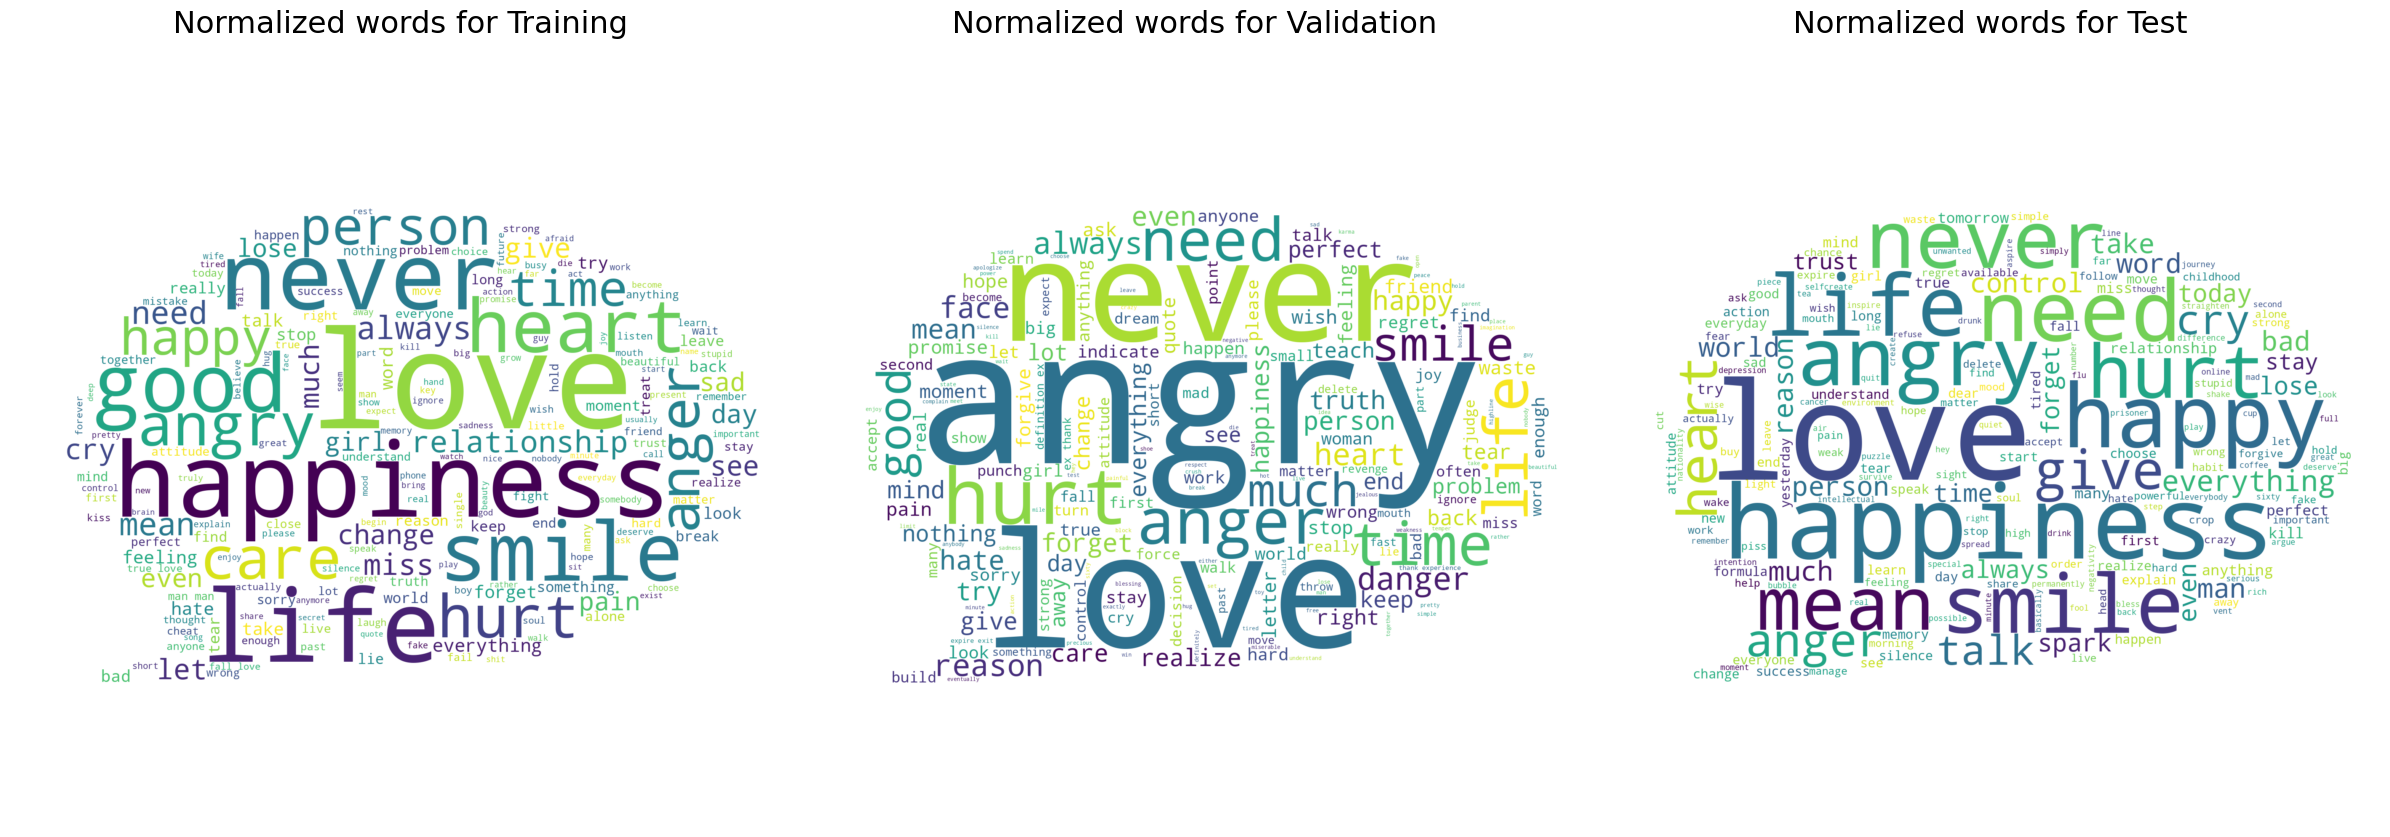

In [385]:
# Load the mask image
comment_mask = np.array(Image.open('/content/drive/MyDrive/Capstone Project/Images/comment.png'))

# Function to generate word cloud
def generate_wordcloud(text, title, ax):
    wc = WordCloud(
        background_color='white',
        max_words=200,
        mask=comment_mask,
    )
    wc.generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontdict={'size': 22, 'verticalalignment': 'bottom'})
    ax.axis('off')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 20))

# Define the categories and corresponding datasets
categories = ['Training', 'Validation', 'Test']
datasets = [data_train_norm, data_val_norm, data_test_norm]

# Generate word clouds for each category and add to subplots
for i, (category, dataset) in enumerate(zip(categories, datasets)):
    text = " ".join(description for description in dataset['normalized content'])
    generate_wordcloud(text, f'Normalized words for {category.capitalize()}', axes[i])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


**TF-IDF Vectorization**

In [386]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized content'].tolist(), data_train_norm['intensity_enc'].tolist()
X_val_norm, y_val = data_val_norm['normalized content'].tolist(), data_val_norm['intensity_enc'].tolist()
X_test_norm, y_test = data_test_norm['normalized content'].tolist(), data_test_norm['intensity_enc'].tolist()

In [387]:
# TF-IDF vectorization
# TfidfVec = TfidfVectorizer()
TfidfVec = TfidfVectorizer(ngram_range = (1, 2),max_features=400) # using both unigram & bi-grams

X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

**TF-IDF Baseline Modeling**

In [388]:
# Classifiers
names = [
    "MultinomialNB",
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    MultinomialNB(),
    LogisticRegression(max_iter = 1000,class_weight= 'balanced'),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(class_weight= 'balanced'),
    svm.SVC(kernel = 'linear', class_weight= 'balanced'),
    RandomForestClassifier(n_estimators = 100, class_weight= 'balanced'),
    SGDClassifier(loss = 'hinge',class_weight= 'balanced'),
    RidgeClassifier(class_weight= 'balanced'),
    XGBClassifier(scale_pos_weight=1),
    AdaBoostClassifier()
]



In [389]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [390]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
5,Random Forest,0.970935,0.691824
0,MultinomialNB,0.798115,0.685535
3,Decision Tree,0.970935,0.654088
8,XGBoost,0.933229,0.654088
1,Logistic Regression,0.825609,0.597484
4,Linear SVM,0.825609,0.597484
6,SGD Classifier,0.879811,0.597484
9,AdaBoost,0.568735,0.597484
2,KNN Classifier,0.570306,0.591195
7,Ridge Classifier,0.838963,0.578616


**Bag of Words Vectorization**

In [391]:
# instantiate the vectorizer
# Bow_vec = CountVectorizer(ngram_range=(1,1))
Bow_vec = CountVectorizer(ngram_range = (1, 2),max_features=450,max_df=0.6) # using both unigram & bi-grams

X_train_bow_vec = Bow_vec.fit_transform(X_train_norm)
X_val_bow_vec = Bow_vec.transform(X_val_norm)
X_test_bow_vec = Bow_vec.transform(X_test_norm)

**BoW Baseline Modeling**

In [392]:
# Summary of baseline models
score(X_train_bow_vec, y_train, X_val_bow_vec, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
5,Random Forest,0.972506,0.685535
8,XGBoost,0.874313,0.679245
3,Decision Tree,0.972506,0.672956
0,MultinomialNB,0.798900,0.660377
4,Linear SVM,0.875884,0.622642
1,Logistic Regression,0.868814,0.610063
6,SGD Classifier,0.912019,0.610063
9,AdaBoost,0.566379,0.610063
7,Ridge Classifier,0.851532,0.572327
2,KNN Classifier,0.448547,0.490566


<div style="background-color:#f5deb3; padding:12px; border-radius:12px">
    <p>Comparing the results of TF-IDF vs. BoW, models fitted using CountVectorization performed better. Therefore, we will only perform hyperparameter tuning on the best-performing model, which is XGBoost using CountVectorizer.</p>
</div>


**Model Evaluation**

In [393]:
import sklearn
import xgboost

print("scikit-learn version:", sklearn.__version__)  # Should be >= 1.0.0
print("xgboost version:", xgboost.__version__)

scikit-learn version: 1.6.1
xgboost version: 2.1.3


In [394]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='accuracy', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid.
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters.
    The combination with the highest accuracy for each class is selected as the default scoring metric.
    The function returns the classifier with the optimal hyperparameters.
    '''

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [395]:
from xgboost import XGBClassifier
xg = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss',num_class=3, scale_pos_weight=1)

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.4, 0.5, 0.1],
    'n_estimators': [150, 200, 250],
    'min_child_weight': [2, 3, 4],
    'scale_pos_weight': [0.2, 0.5, 0.8],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.3, 0.5, 0.8],
    'colsample_bylevel': [0.5, 0.7, 0.9],
    'reg_alpha': [0.01, 0.05, 0.1],
    'reg_lambda': [0.05, 0.1, 0.2],
    'max_delta_step': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

In [396]:
# Initialize the XGBoost Classifier using optimal hyperparameters
xgb_opt = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    n_estimators=250,
    max_depth=8,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
    colsample_bylevel=0.5,
    min_child_weight=4,
    max_delta_step=2,
)

# Train the XGBoost classifier
xgb_opt.fit(X_train_bow_vec, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=2, max_depth=8,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [397]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Evaluate the model on the train data
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, model.predict(X_train), target_names=['happiness', 'angriness', 'sadness']))

    # Evaluate the model on the test data
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, model.predict(X_test),target_names=['happiness', 'angriness', 'sadness']))


    # Generate confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))

    # Define the class labels
    class_labels = ['happiness', 'angriness', 'sadness']

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test, model.predict_proba(X_test)[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()

    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

   happiness       0.77      0.87      0.82       561
   angriness       0.78      0.75      0.76       402
     sadness       0.78      0.64      0.70       310

    accuracy                           0.78      1273
   macro avg       0.78      0.75      0.76      1273
weighted avg       0.78      0.78      0.77      1273


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

   happiness       0.73      0.64      0.69        76
   angriness       0.58      0.65      0.61        48
     sadness       0.62      0.69      0.65        35

    accuracy                           0.65       159
   macro avg       0.64      0.66      0.65       159
weighted avg       0.66      0.65      0.66       159



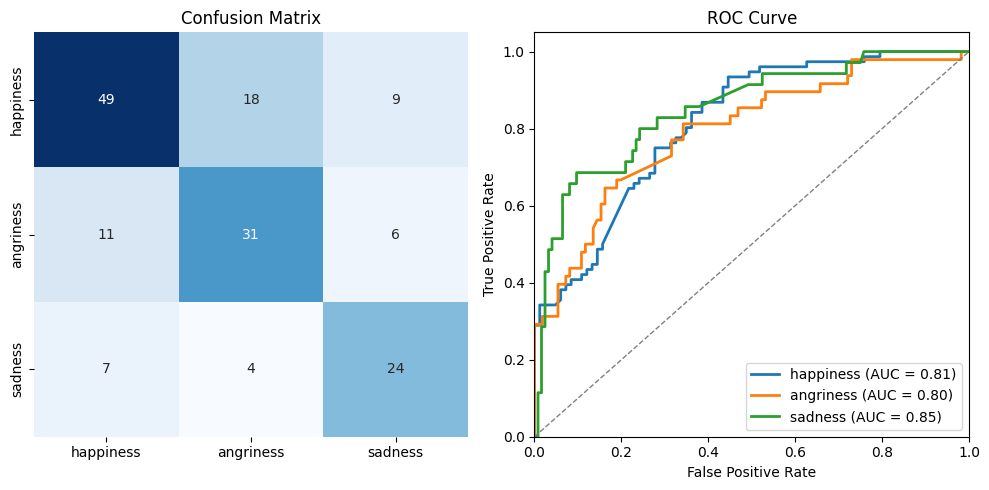

In [398]:
evaluate_model(xgb_opt, X_train_bow_vec, y_train, X_val_bow_vec, y_val)

<div style="background-color:#f5deb3; padding:12px; border-radius:12px">The model achieves solid performance on the training set and maintains a reasonable performance on the test set, indicating it can generalize to new data. The higher precision and recall for "happiness" across both sets suggest that this emotion is more easily identifiable by the model, while "angriness" and "sadness" present more challenges, likely due to the nuanced nature of these emotions in text. The slight drop in test accuracy suggests minimal overfitting, but the overall results are promising for practical applications in emotion prediction from text.

In [399]:
import joblib

# Save the model
joblib.dump(xgb_opt, 'best_xgb_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(Bow_vec, 'bow_vectorizer.pkl')

['bow_vectorizer.pkl']

**Word2Vec Model**

In [400]:
wv = api.load('word2vec-google-news-300')

In [401]:

for df in [data_train, data_val, data_test]:
  df['tokens'] = (df["content"].apply(convert_to_lowercase)
                                .apply(remove_http)
                                .apply(remove_problematic)
                                .apply(convert_acronyms)
                                .apply(convert_contractions)
                                .apply(convert_abbrev_in_text)
                                .apply(pyspellchecker)
                                  .apply(regexp.tokenize))
data_train[['tokens', 'intensity_enc']]

,tokens,intensity_enc
49,"[anger, is, a, condition, in, which, the, tong...",1
293,"[do, not, put, words, into, my, mouth, i, have...",1
893,"[new, relationship, quotes]",0
520,"[i, am, a, very, private, person, you, do, not...",1
438,"[happiness, is, not, a, goal, it, is, a, by, p...",0
...,...,...
65,"[i, have, tried, and, tried, and, now, i, give...",1
1524,"[i, hate, that, i, cry, when, i, am, frustrate...",1
1288,"[laughing, while, kissing, means, i, am, compl...",0
469,"[i, miss, your, name, lighting, up, my, phone]",2


In [402]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)


def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)

    color_mapper = {label: idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]

    # Use distinct colors for the categories
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))

    # Create legend patches dynamically from category_mapping
    handles = [mpatches.Patch(color = colors[idx], label = label) for label, idx in color_mapper.items()]

    plt.legend(handles = handles, prop = {"size": 10}, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D Scatter Plot of Categories')
    plt.show()


**Word2Vec embedding**

<Figure size 800x700 with 0 Axes>

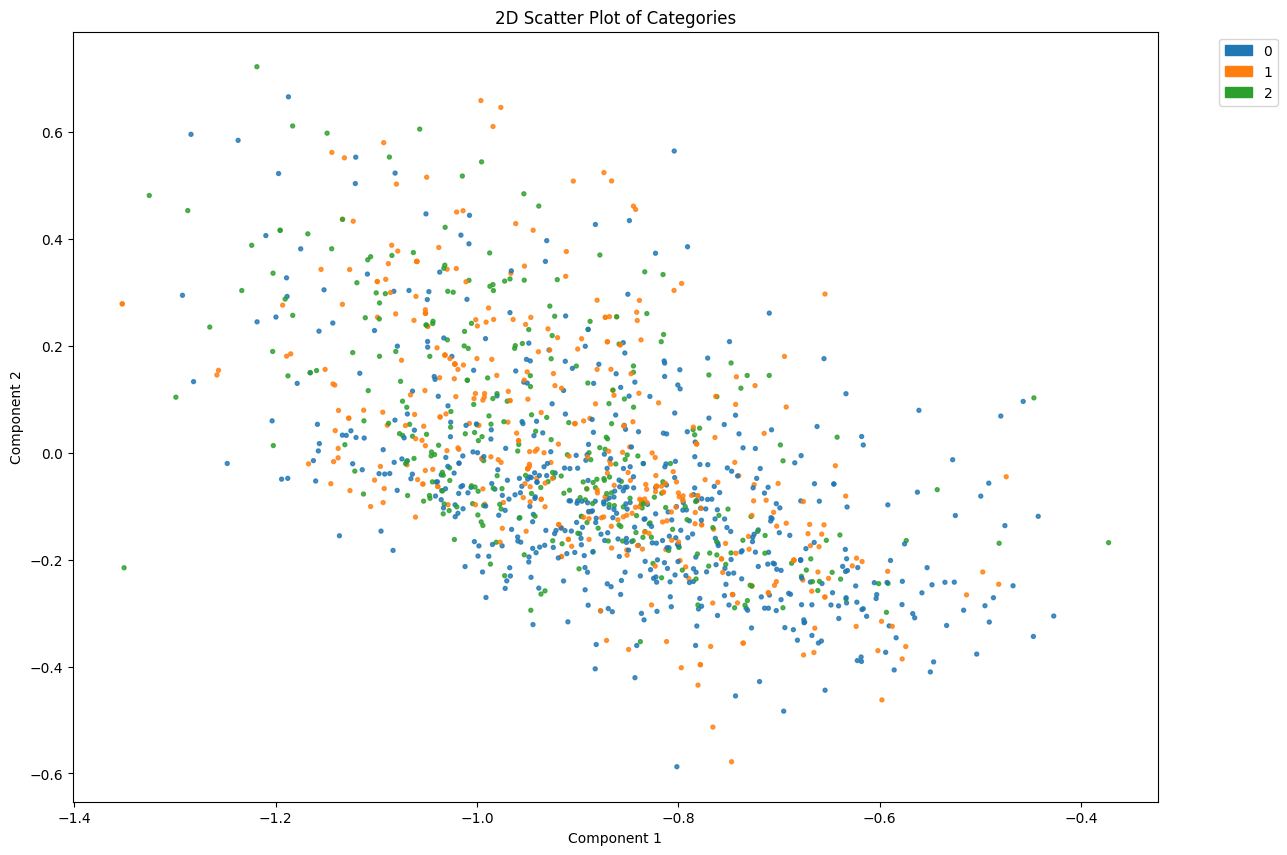

In [403]:

X_train_embed = get_word2vec_embeddings(wv, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(wv, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(wv, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))
plot_embedding(X_train_embed, y_train)
plt.show()

In [404]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

**Word2Vec Baseline Modeling**

In [405]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000,class_weight= 'balanced'),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100, class_weight= 'balanced'),
    SGDClassifier(loss = 'hinge',class_weight= 'balanced'),
    RidgeClassifier(class_weight= 'balanced'),
    XGBClassifier(scale_pos_weight=1),
    AdaBoostClassifier()
]

# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
5,SGD Classifier,0.833464,0.660377
3,Linear SVM,0.756481,0.647799
0,Logistic Regression,0.750196,0.641509
6,Ridge Classifier,0.787117,0.641509
7,XGBoost,0.993716,0.622642
4,Random Forest,0.993716,0.616352
2,Decision Tree,0.993716,0.603774
1,KNN Classifier,0.578162,0.547170
8,AdaBoost,0.713276,0.540881


**Word2Vec Hyperparameter Tuning**

<div style="background-color:#f5deb3; padding:12px;border-radius:12px">
    <p>We perform <b>hyperparameter tuning</b> on the best performing baseline model</p>

In [406]:
svm_classifier = svm.SVC(kernel = 'linear',probability=True)
params_svm = {
    'C': [0.1, 1, 10, 100]
}

In [407]:
# Call the function for hyperparameter tuning
best_linear_svm, best_svc_hyperparams = tune_clf_hyperparameters(svm_classifier, params_svm, X_train_w2v, y_train)
print(' Linear SVM Optimal Hyperparameters: \n', best_svc_hyperparams)

 Linear SVM Optimal Hyperparameters: 
 {'C': 1}


**Model Evaluation**


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

   happiness       0.77      0.87      0.81       561
   angriness       0.73      0.80      0.76       402
     sadness       0.79      0.50      0.62       310

    accuracy                           0.76      1273
   macro avg       0.76      0.72      0.73      1273
weighted avg       0.76      0.76      0.75      1273


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

   happiness       0.69      0.72      0.71        76
   angriness       0.62      0.65      0.63        48
     sadness       0.59      0.49      0.53        35

    accuracy                           0.65       159
   macro avg       0.63      0.62      0.62       159
weighted avg       0.64      0.65      0.64       159



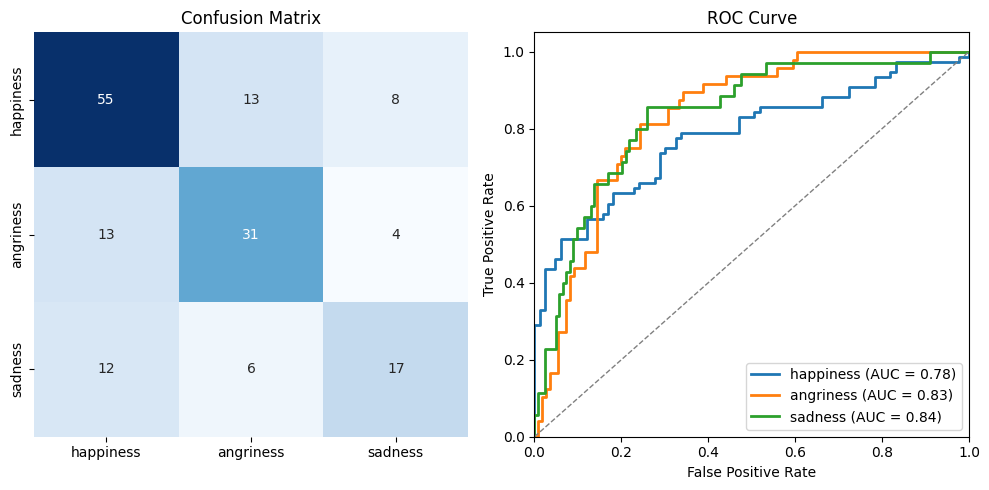

In [408]:
evaluate_model(best_linear_svm, X_train_w2v, y_train, X_val_w2v, y_val)

<div style="background-color:#f5deb3; padding:12px;border-radius:12px">
After doing hypertunning, the model is performing well, got accuracy: <b>71%, minimal overfitting.</b>

<div style="background-color:#f5deb3; padding:12px;border-radius:12px">Given that our current dataset is relatively small and deep learning models typically require large amounts of data to perform optimally, we plan to collect more data in the future. This will help our models to better predict emotions and identify patterns more effectively

**Conclusion**

In [420]:
data = {
    'model_name': [
        'Linear_svm_hyper_w2v',
         'XGBoost_hyper_bow',
        'XGBoost_tfidf',



    ],
    'training_accuracy': [
        0.84,
        0.82,
        0.77
    ],
    'validation_accuracy': [
        0.71,
        0.70,
        0.67
    ],
    'is_overfitting': [
        "No",  # XGBoost_tfidf has a large gap between training and validation accuracy
        "No", # XGBoost_hyper_bow has a smaller gap
       "No", # Linear_svm_hyper_w2v has a very small gap
    ]
}

results = pd.DataFrame(data)
results


,model_name,training_accuracy,validation_accuracy,is_overfitting
0,Linear_svm_hyper_w2v,0.84,0.71,No
1,XGBoost_hyper_bow,0.82,0.70,No
2,XGBoost_tfidf,0.77,0.67,No


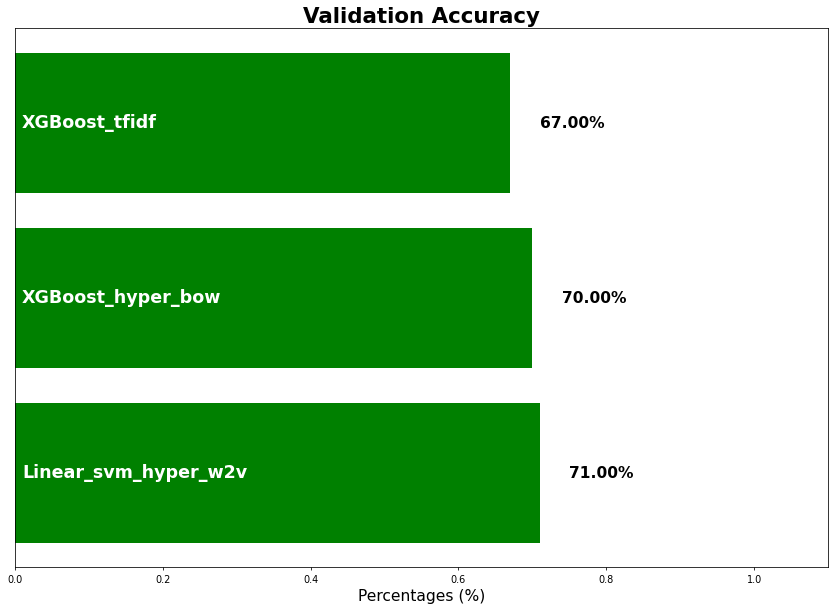

In [421]:
import matplotlib.pyplot as plt
# Prepare values
results.sort_values(by='validation_accuracy', ascending=False, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 10), dpi=70)
ax.barh(results.index, results['validation_accuracy'], color='green')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(results['validation_accuracy'], results['model_name'])):
    ax.text(value + 0.04, i, f"{value:.2%}", ha='left', va='center', fontweight='bold', color='black', fontsize=16)
    ax.text(0.01, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.10])

# Add title and xlabel
plt.title("Validation Accuracy", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

<div style="background-color:#f5deb3; padding:12px;border-radius:12px">
    <p>The <b>Linear SVM with Word2Vec</b> appears to be the best model in terms of generalization, with minimal overfitting and a relatively high validation accuracy of 71%. This suggests that this model can effectively predict emotions on new, unseen data. Additionally, the data is related to <b>WhatsApp chat analysis</b> of most <b>Indian users</b>. Indians often chat in their <b>native language but type it in English</b>, making it difficult for the model to understand 'Indian slangs'.</p>

</div>
